# Imports and EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import requests
from io import BytesIO
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


In [62]:
train_data=pd.read_csv('/kaggle/input/assignment-data-1/parspec_train_data.csv')
test_data=pd.read_csv('/kaggle/input/assignment-data-1/parspec_test_data.csv')
train_data.head()

,ID,URL,Is lighting product?
0,P-0,https://a4b6eb24-cef6-4be0-88b1-aa225dd7e4f7.u...,Yes
1,P-1,https://a4b6eb24-cef6-4be0-88b1-aa225dd7e4f7.u...,Yes
2,P-2,https://myelektralite.com/assets/1018-AI-Outdo...,Yes
3,P-3,https://myelektralite.com/assets/1018-Data-She...,Yes
4,P-4,https://myelektralite.com/assets/1018AI-Data-S...,Yes


In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    1000 non-null   object
 1   URL                   1000 non-null   object
 2   Is lighting product?  1000 non-null   object
dtypes: object(3)
memory usage: 23.9+ KB


In [64]:
len(train_data)

1013

In [65]:
train_data.isna().sum()

ID                      13
URL                     13
Is lighting product?    13
dtype: int64

In [66]:
train_data.duplicated().sum()

12

In [67]:
train_data[train_data.duplicated()]

,ID,URL,Is lighting product?
858,NaN,NaN,NaN
859,NaN,NaN,NaN
860,NaN,NaN,NaN
861,NaN,NaN,NaN
862,NaN,NaN,NaN
863,NaN,NaN,NaN
864,NaN,NaN,NaN
926,NaN,NaN,NaN
928,NaN,NaN,NaN
933,NaN,NaN,NaN


#Total 13 missing values

<Axes: xlabel='Is lighting product?'>

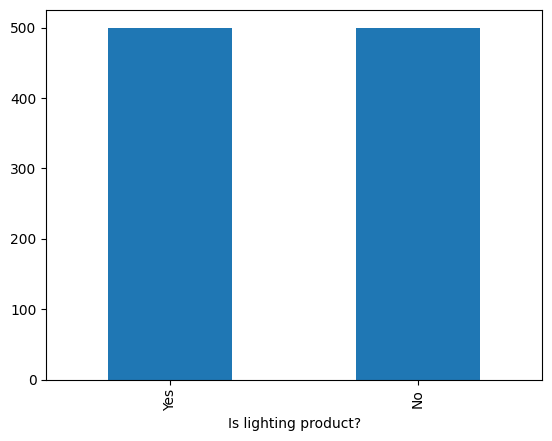

In [4]:
train_data['Is lighting product?'].value_counts().plot.bar()

No class imbalance.

In [ ]:
test_data.isna().sum()

In [5]:
train_data.dropna(axis=0,inplace=True)
train_data.isna().sum()

ID                      0
URL                     0
Is lighting product?    0
dtype: int64

In [ ]:
train_data.info()

In [6]:
!pip install pypdf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.6 MB/s eta 0:00:00a 0:00:01


# Extracting and Preprocessing Text

extract_text function takes url,extracts text from that link using PyPDF2 and preprocesses it. 

In [7]:
# extracts text data from pdfs and preprocesses it.
import PyPDF2
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens if token.isalnum() and token not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text
def extract_and_preprocess_text(url,index):
    try:
        response = requests.get(url)
        with BytesIO(response.content) as f:
            pdf_reader = PyPDF2.PdfReader(f)
            text = ''
            for page in pdf_reader.pages:
                text += page.extract_text()
        return preprocess_text(text)
    except Exception as e:
        print(f"Error processing URL at index{index}: {e}")
        return ""
    
def extract_text(data):   
    
    for index, row in data.iterrows():
        try:
            text = extract_and_preprocess_text(row['URL'],index)
            data['URL'][index]=text
        except Exception as e:
            print(f"Error processing URL at index {index}: {e}")
            data['URL'][index]=None 
    data=data[data['URL']!=""]
    labels = {'Yes': 1, 'No': 0}
    labels=data['Is lighting product?'].map(labels)
    return data, labels
            
data,labels=extract_text(train_data)

Error processing URL at index2: EOF marker not found
Error processing URL at index3: EOF marker not found
Error processing URL at index4: EOF marker not found
Error processing URL at index5: EOF marker not found
Error processing URL at index6: EOF marker not found
Error processing URL at index7: EOF marker not found
Error processing URL at index8: EOF marker not found
Error processing URL at index9: EOF marker not found
Error processing URL at index10: EOF marker not found
Error processing URL at index11: EOF marker not found
Error processing URL at index62: EOF marker not found
Error processing URL at index63: EOF marker not found
Error processing URL at index64: EOF marker not found
Error processing URL at index65: EOF marker not found
Error processing URL at index66: EOF marker not found
Error processing URL at index67: EOF marker not found
Error processing URL at index68: EOF marker not found
Error processing URL at index69: EOF marker not found
Error processing URL at index70: EOF

In [8]:
def extract_test_text(data):   
    
    for index, row in data.iterrows():
        try:
            text = extract_and_preprocess_text(row['URL'],index)
            data.loc[index,'URL']=text
        except Exception as e:
            print(f"Error processing URL at index {index}: {e}")
    data=data[data['URL']!=""]
    labels=data['Is lighting product?']
    return data, labels
test_data,test_labels=extract_test_text(test_data)

# Encoding (TF-IDF, Bag-of-words)

Here, we'e using two encoders, Bag-of-words and TF-IDF and train models on both encoder features. 

In [30]:
#tfidf
def vectorizer(data):
    tfidf_vectorizer = TfidfVectorizer(max_features=8000,max_df=0.9,min_df=0.1,sublinear_tf=True,use_idf=True,ngram_range=(1, 2))
    tfidf_features = tfidf_vectorizer.fit_transform(data['URL'])
    return tfidf_vectorizer,tfidf_features


tfidf_vectorizer,trian_tfidf_features=vectorizer(data)

In [31]:
test_tfidf_features=tfidf_vectorizer.transform(test_data['URL'])

train_tfidf_features, labels -->tfidf vectorized training data

test_tfidf_features,test_labels -->tfidf vectorized test data

Bag-Of-Words

In [42]:
from sklearn.feature_extraction.text import CountVectorizer #bag of words
def bag_of_words(data):
    bg_vectorizer=CountVectorizer()
    bg_train = bg_vectorizer.fit_transform(data['URL'])
    return bg_train,bg_vectorizer
bg_train,bg_vectorizer=bag_of_words(data)
bg_test=bg_vectorizer.transform(test_data['URL'])

bg_train,labels ---> BOW vectorized training data 

bg_test,test_labels ---> BOW vectorized test data

# Training with bag of words features

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
def scores(true_labels,predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='binary', pos_label=1)
    recall = recall_score(true_labels, predicted_labels, average='binary', pos_label=1)
    f1 = f1_score(true_labels, predicted_labels, average='binary', pos_label=1)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

In [43]:
#SVC
from sklearn.svm import SVC
classifier = SVC(C=10,gamma=1,kernel='rbf')
classifier.fit(bg_train, labels)
predicted_labels=classifier.predict(bg_test)
scores(test_labels,predicted_labels)
print(classifier.score(bg_test,test_labels))

Precision: 0.2500
Recall: 1.0000
F1-score: 0.4000
0.25


In [50]:
from sklearn.ensemble import RandomForestClassifier

bg_rf_classifier = RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_leaf=2,min_samples_split=5, random_state=42)

bg_rf_classifier.fit(bg_train, labels)
predicted_labels=bg_rf_classifier.predict(bg_test)
scores(test_labels,predicted_labels)
print(bg_rf_classifier.score(bg_test,test_labels))

Precision: 0.7600
Recall: 0.9500
F1-score: 0.8444
0.9125


In [47]:
from sklearn.model_selection import GridSearchCV
rf_clf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(bg_train, labels)

# Get the best parameters
best_params = grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [48]:
best_params

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [51]:
from sklearn.linear_model import LogisticRegression
lg_classifier=LogisticRegression(C=1,penalty='l2',solver='liblinear',max_iter=1000)
lg_classifier.fit(bg_train, labels)
predicted_labels=lg_classifier.predict(bg_test)
scores(test_labels,predicted_labels)
print(lg_classifier.score(bg_test,test_labels))

Precision: 0.4615
Recall: 0.9000
F1-score: 0.6102
0.7125


In [52]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(random_state=42)

xgb_classifier.fit(bg_train, labels)
predicted_labels=xgb_classifier.predict(bg_test)
scores(test_labels,predicted_labels)
print(xgb_classifier.score(bg_test,test_labels))

Precision: 0.4651
Recall: 1.0000
F1-score: 0.6349
0.7125


**Random Forest Classifier is the best model with 91 percent accuracy,F1 score of 0.84**

# Training with TF-IDF

In [54]:
rf_clf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(trian_tfidf_features, labels)
best_params = grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END 

In [55]:
best_params

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [56]:


rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_leaf=2,min_samples_split=10, random_state=42)

rf_classifier.fit(trian_tfidf_features, labels)
predicted_labels=rf_classifier.predict(test_tfidf_features)
scores(test_labels,predicted_labels)
print(rf_classifier.score(test_tfidf_features,test_labels))

Precision: 0.6250
Recall: 1.0000
F1-score: 0.7692
0.85


In [57]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC


rf_model = RandomForestClassifier(n_estimators=200,max_depth=None,min_samples_leaf=4,min_samples_split=10, random_state=42)
svm_model = SVC(probability=True)
#lgc_model=LogisticRegression(C=1,penalty='l2',solver='liblinear',max_iter=1000)
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('svm', svm_model)
], voting='soft')  


voting_classifier.fit(trian_tfidf_features, labels)

predictions = voting_classifier.predict(test_tfidf_features)

scores(test_labels,predictions)
print(voting_classifier.score(test_tfidf_features,test_labels))


Precision: 0.7391
Recall: 0.8500
F1-score: 0.7907
0.8875


In [36]:
from sklearn.linear_model import LogisticRegression
lg_classifier=LogisticRegression(C=1,penalty='l2',solver='liblinear',max_iter=1000)
lg_classifier.fit(trian_tfidf_features, labels)
predicted_labels=lg_classifier.predict(test_tfidf_features)
scores(test_labels,predicted_labels)
print(lg_classifier.score(test_tfidf_features,test_labels))

Precision: 0.7391
Recall: 0.8500
F1-score: 0.7907
0.8875


In [37]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(trian_tfidf_features, labels)
predicted_labels=naive_bayes.predict(test_tfidf_features)
scores(test_labels,predicted_labels)
print(naive_bayes.score(test_tfidf_features,test_labels))


Precision: 0.7500
Recall: 0.9000
F1-score: 0.8182
0.9


In [26]:
logreg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(trian_tfidf_features, labels)
best_params = grid_search.best_params_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [27]:
best_params

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [58]:

import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(random_state=42)

xgb_classifier.fit(trian_tfidf_features, labels)
predicted_labels=xgb_classifier.predict(test_tfidf_features)
scores(test_labels,predicted_labels)
print(xgb_classifier.score(test_tfidf_features,test_labels))

Precision: 0.5000
Recall: 0.7500
F1-score: 0.6000
0.75


In [61]:
import joblib
joblib.dump(bg_vectorizer, 'bg_vectorizer_main.pkl')
joblib.dump(bg_rf_classifier, 'rf_model_bg.pkl')

['rf_model_bg.pkl']